In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

In [2]:
travel_churn_data = pd.read_csv('./datasets/customer_travel.csv')

travel_churn_data.head()

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
0,34,No,Middle Income,6,No,Yes,0
1,34,Yes,Low Income,5,Yes,No,1
2,37,No,Middle Income,3,Yes,No,0
3,30,No,Middle Income,2,No,No,0
4,30,No,Low Income,1,No,No,0


In [3]:
travel_churn_data.columns

Index(['Age', 'FrequentFlyer', 'AnnualIncomeClass', 'ServicesOpted',
       'AccountSyncedToSocialMedia', 'BookedHotelOrNot', 'Target'],
      dtype='object')

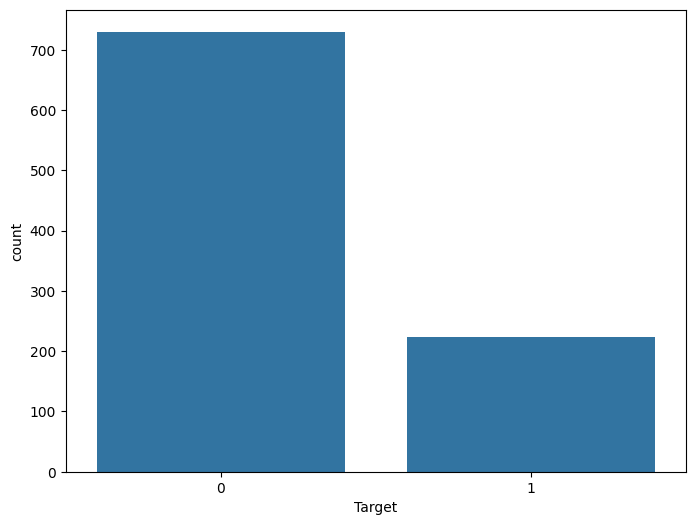

In [4]:
plt.subplots(figsize = (8, 6))

sns.countplot(x = 'Target', data = travel_churn_data)
plt.show()

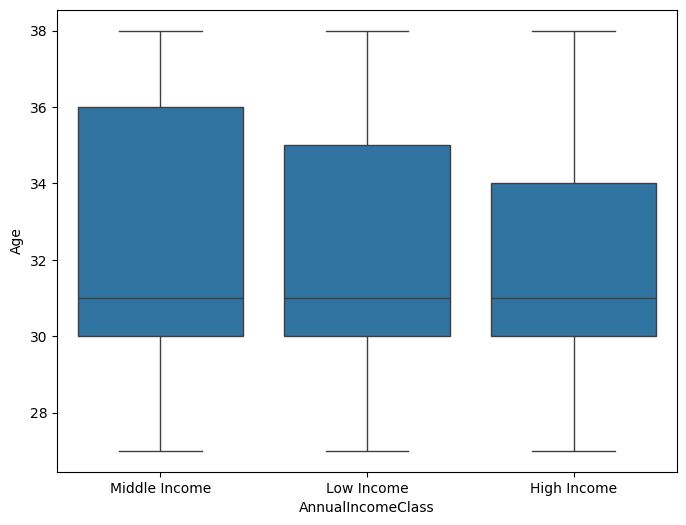

In [5]:
plt.subplots(figsize = (8, 6))

sns.boxplot(x = 'AnnualIncomeClass', y = 'Age', data = travel_churn_data)
plt.show()

In [6]:
travel_churn_data['AnnualIncomeClass'].unique()

array(['Middle Income', 'Low Income', 'High Income'], dtype=object)

In [7]:
mapper = {'Low Income': 0,'Middle Income': 1, 'High Income': 2}

travel_churn_data['AnnualIncomeClass'] = travel_churn_data['AnnualIncomeClass'].replace(mapper)

C:\Users\achla\AppData\Local\Temp\ipykernel_12964\2425412443.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  travel_churn_data['AnnualIncomeClass'] = travel_churn_data['AnnualIncomeClass'].replace(mapper)


In [8]:
travel_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Age                         954 non-null    int64 
 1   FrequentFlyer               954 non-null    object
 2   AnnualIncomeClass           954 non-null    int64 
 3   ServicesOpted               954 non-null    int64 
 4   AccountSyncedToSocialMedia  954 non-null    object
 5   BookedHotelOrNot            954 non-null    object
 6   Target                      954 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 52.3+ KB


In [9]:
categorical_features = [
    'FrequentFlyer','AccountSyncedToSocialMedia', 'BookedHotelOrNot']

categorical_transformer = Pipeline(
    steps = [('encoder', OneHotEncoder(handle_unknown = 'ignore', drop = 'first'))])
    
preprocessor = ColumnTransformer(
    transformers = [("cat", categorical_transformer, categorical_features)], 
    remainder = StandardScaler()
)

In [10]:
X = travel_churn_data.drop(labels = ['Target'], axis = 1)
 
y = travel_churn_data['Target']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 124)

In [11]:
X_train.shape, X_test.shape

((763, 6), (191, 6))

In [12]:
import mlflow
import mlflow.sklearn

In [13]:
import mlflow

mlflow.get_tracking_uri()

'file:///C:/Users/achla/Downloads/ML/work/mlflow_model_registration/mlruns'

In [14]:
mlflow.set_experiment(experiment_name = 'customer_churn_prediction1')

<Experiment: artifact_location='mlflow-artifacts:/417882718673025605', creation_time=1759216424756, experiment_id='417882718673025605', last_update_time=1759216424756, lifecycle_stage='active', name='customer_churn_prediction1', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [15]:
mlflow.set_tracking_uri('http://localhost:5000')

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from mlflow.models.signature import infer_signature
 
with mlflow.start_run(run_name = 'logistic_model') as logistic_run:
 
    lr_model = LogisticRegression()
    
    pipe_lr = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', lr_model)])
    pipe_lr.fit(X_train, y_train)
 
    predictions = pipe_lr.predict(X_test)

    predictions_predict_prob = pipe_lr.predict_proba(X_test)
    
    train_accuracy_score = pipe_lr.score(X_train, y_train)
    
    test_accuracy_score = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
    model_params = lr_model.get_params()
    mlflow.log_params(model_params)

    metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score
    }
    
    mlflow.log_metrics(metrics)
    
    # Explicit model signature creation
    from mlflow.models.signature import ModelSignature
    from mlflow.types.schema import Schema, ColSpec
    
    input_schema = Schema(
    [
        ColSpec('long', 'Age'),
        ColSpec('string', 'FrequentFlyer'),
        ColSpec('long', 'AnnualIncomeClass'),
        ColSpec('long', 'ServicesOpted'),
        ColSpec('string', 'AccountSyncedToSocialMedia'),
        ColSpec('string', 'BookedHotelOrNot')
    ]
)
    output_schema = Schema([ColSpec('integer')])
    signature = ModelSignature(inputs = input_schema, outputs = output_schema)


    mlflow.sklearn.log_model(
        lr_model, name='preprocessing_pipeline_with_logistic_regression_model', 
        signature = signature)
    
    mlflow.set_tag('Classifier', 'logistic regression default parameters')

🏃 View run logistic_model at: http://localhost:5000/#/experiments/417882718673025605/runs/8770df6d767b4842abe50db2ca1c5f4a
🧪 View experiment at: http://localhost:5000/#/experiments/417882718673025605


In [17]:
!pip install shap

  Using cached shap-0.48.0-cp313-cp313-win_amd64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached numba-0.62.1-cp313-cp313-win_amd64.whl.metadata (2.9 kB)
  Using cached llvmlite-0.45.0-cp313-cp313-win_amd64.whl.metadata (5.0 kB)
Using cached shap-0.48.0-cp313-cp313-win_amd64.whl (545 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Using cached numba-0.62.1-cp313-cp313-win_amd64.whl (2.7 MB)
Using cached llvmlite-0.45.0-cp313-cp313-win_amd64.whl (37.9 MB)

   ---------- ----------------------------- 1/4 [llvmlite]
   ---------- ----------------------------- 1/4 [llvmlite]
   ---------- ----------------------------- 1/4 [llvmlite]
   ---------- ----------------------------- 1/4 [llvmlite]
   ---------- ----------------------------- 1/4 [llvmlite]
   ---------- ----------------------------- 1/4 [llvmlite]
   ---------- ----------------------------- 1/4 [llvmlite]
   ---------- ----------------------------- 1/4 [llvmlite]
   -------

In [18]:
import mlflow.shap

with mlflow.start_run(run_name = 'logistic model with explanation') as logistic_run:
 
    lr_model = LogisticRegression()
    
    pipe_lr = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', lr_model)])
    pipe_lr.fit(X_train, y_train)
 
    predictions =  pipe_lr.predict(X_test)
    predictions_predict_prob =   pipe_lr.predict_proba(X_test)
    
    train_accuracy_score =   pipe_lr.score(X_train, y_train)
    
    test_accuracy_score = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
    model_params = lr_model.get_params()
    mlflow.log_params(model_params)

    metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score 
    }
    
    mlflow.log_metrics(metrics)
    
    # Infer the signature based on the training data
    signature = infer_signature(X_train, pipe_lr.predict(X_train))
    
    # Compute Shapley values
    observations =  pipe_lr.named_steps['preprocessor'].transform(X_train)
    
    observations_asframe =  pd.DataFrame(
        observations , columns = preprocessor.get_feature_names_out())
    
    print(observations_asframe)
    
    mlflow.shap.log_explanation(
        pipe_lr.named_steps['classifier'].predict, observations_asframe)

    mlflow.sklearn.log_model(
        pipe_lr, 
        name ='preprocessing_pipeline_with_logistic_regression_model', 
        signature = signature
    )
    
   # mlflow.sklearn.log_model(sk_model, name="sk_models", signature=signature)
    
    mlflow.set_tag('Classifier', 'logistic regression default parameters')
    mlflow.set_tag('Explanation', 'true')

C:\Users\achla\Downloads\ML\work\mlflow_evnv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


     cat__FrequentFlyer_No Record  cat__FrequentFlyer_Yes  \
0                             0.0                     0.0   
1                             0.0                     0.0   
2                             0.0                     0.0   
3                             0.0                     0.0   
4                             0.0                     0.0   
..                            ...                     ...   
758                           0.0                     1.0   
759                           0.0                     0.0   
760                           0.0                     1.0   
761                           0.0                     0.0   
762                           0.0                     0.0   

     cat__AccountSyncedToSocialMedia_Yes  cat__BookedHotelOrNot_Yes  \
0                                    1.0                        0.0   
1                                    1.0                        0.0   
2                                    0.0              

  0%|          | 0/763 [00:00<?, ?it/s]

🏃 View run logistic model with explanation at: http://localhost:5000/#/experiments/417882718673025605/runs/16c06bb0182c4de19e92b7fd482a0969
🧪 View experiment at: http://localhost:5000/#/experiments/417882718673025605


In [19]:
import os
from mlflow import MlflowClient

client = MlflowClient()

artifact_path = 'model_explanations_shap'

artifacts = [
    x.path for x in client.list_artifacts(
        logistic_run.info.run_id, artifact_path)
]

print('# artifacts:')
print(artifacts)

# Load back the logged explanation
dst_path = mlflow.artifacts.download_artifacts(run_id = logistic_run.info.run_id)

dst_path = os.path.join(dst_path, artifact_path)

print(dst_path)

base_values = np.load(os.path.join(dst_path, 'base_values.npy'))
shap_values = np.load(os.path.join(dst_path, 'shap_values.npy'))

print('\n# base_values:')
print(base_values)
print('\n# shap_values:')
print(shap_values)

# artifacts:
['model_explanations_shap/base_values.npy', 'model_explanations_shap/shap_values.npy', 'model_explanations_shap/summary_bar_plot.png']


C:\Users\achla\AppData\Local\Temp\tmpiw0q2ybf\model_explanations_shap

# base_values:
0.17038007863695936

# shap_values:
[[ 0.         -0.1088685   0.01727829 ... -0.08953692  0.00061162
  -0.00412844]
 [ 0.         -0.24394932  0.02341634 ...  0.0419834   0.00061162
  -0.01393622]
 [ 0.         -0.22518567 -0.00633464 ...  0.04643949 -0.00318917
  -0.00301442]
 ...
 [ 0.          0.52719528  0.03488423 ...  0.14722586 -0.00550459
  -0.0429882 ]
 [ 0.         -0.10364788 -0.0143294  ... -0.07208388 -0.00268676
   0.00797291]
 [ 0.         -0.19547837  0.03038445 ...  0.05812582 -0.00183486
  -0.01168633]]


In [20]:
mlflow.sklearn.autolog()

# Need to re-import these after turning on autolog
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

with mlflow.start_run(run_name = 'logistic model with autologging'):
 
    lr_model = LogisticRegression()
    
    pipe_lr = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', lr_model)])
    pipe_lr.fit(X_train, y_train)
 
    predictions =  pipe_lr.predict(X_test)
    predictions_predict_prob =  pipe_lr.predict_proba(X_test)
    
    test_accuracy_score = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    
    # Needs to be logged explicitly since it is not autologged
    auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    mlflow.log_metric('AUC_score', auc_score)
      
    signature = infer_signature(X_train,  pipe_lr.predict(X_train))
 
    mlflow.set_tag('Classifier', 'logistic regression default parameters')

2025/09/30 15:54:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\achla\Downloads\ML\work\mlflow_evnv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/09/30 15:54:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\achla\Downloads\ML\work\ml

🏃 View run logistic model with autologging at: http://localhost:5000/#/experiments/417882718673025605/runs/9e7499429d66439785b128476c8fa9ec
🧪 View experiment at: http://localhost:5000/#/experiments/417882718673025605


In [21]:
mlflow.sklearn.autolog()

# Need to re-import these after turning on autolog
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

with mlflow.start_run(run_name = 'random forest model default parameters'):
  
    rf_model = RandomForestClassifier()
    
    pipe_rf = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', rf_model)])
    pipe_rf.fit(X_train, y_train)
 
    predictions =  pipe_rf.predict(X_test)
    predictions_predict_prob = pipe_rf.predict_proba(X_test)
    
    test_accuracy_score = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    
    auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    mlflow.log_metric('AUC_score', auc_score)
      
    signature = infer_signature(X_train, pipe_rf.predict(X_train))
 
    mlflow.set_tag('Classifier', 'random forest default parameters')

2025/09/30 15:55:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\achla\Downloads\ML\work\mlflow_evnv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/09/30 15:55:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\achla\Downloads\ML\work\ml

🏃 View run random forest model default parameters at: http://localhost:5000/#/experiments/417882718673025605/runs/d4ab383a39f24b51a3e40507aebf1ed4
🧪 View experiment at: http://localhost:5000/#/experiments/417882718673025605


In [22]:
# Does not support prediction probability
from sklearn.svm import SVC

mlflow.sklearn.autolog()

# Need to re-import these after turning on autolog
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

with mlflow.start_run(run_name = 'SVC model default parameters'):
 
    svc_model = SVC()
    
    pipe_svc = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', svc_model)])
    pipe_svc.fit(X_train, y_train)
 
    predictions =  pipe_svc.predict(X_test)
    
    test_accuracy_score = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    
    signature = infer_signature(X_train, pipe_svc.predict(X_train))
 
    mlflow.set_tag('Classifier', 'SVC default parameters')

2025/09/30 15:57:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\achla\Downloads\ML\work\mlflow_evnv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/09/30 15:57:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\achla\Downloads\ML\work\ml

🏃 View run SVC model default parameters at: http://localhost:5000/#/experiments/417882718673025605/runs/8c53c47004294842aa3744f04c1838d2
🧪 View experiment at: http://localhost:5000/#/experiments/417882718673025605


In [23]:
from sklearn.ensemble import GradientBoostingClassifier

mlflow.sklearn.autolog()

# Need to re-import these after turning on autolog
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

with mlflow.start_run(run_name = 'gradient boosting model default parameters'):
 
    gb_model = GradientBoostingClassifier()
    
    pipe_gb = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', gb_model)])
    pipe_gb.fit(X_train, y_train)
    
    predictions =  pipe_gb.predict(X_test)
    predictions_predict_prob = pipe_gb.predict_proba(X_test)
    
    test_accuracy_score = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    
    auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    mlflow.log_metric('AUC_score', auc_score)
    
    signature = infer_signature(X_train, pipe_gb.predict(X_train))
 
    mlflow.set_tag('Classifier', 'gradient boosting default parameters')

2025/09/30 15:58:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\achla\Downloads\ML\work\mlflow_evnv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/09/30 15:58:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\achla\Downloads\ML\work\ml

🏃 View run gradient boosting model default parameters at: http://localhost:5000/#/experiments/417882718673025605/runs/f5737aa5128b46d0a9a2cf6eb6d665ad
🧪 View experiment at: http://localhost:5000/#/experiments/417882718673025605


In [24]:
client = mlflow.tracking.MlflowClient()
experiments_list = client.search_experiments()

experiments_list

[<Experiment: artifact_location='mlflow-artifacts:/417882718673025605', creation_time=1759216424756, experiment_id='417882718673025605', last_update_time=1759216424756, lifecycle_stage='active', name='customer_churn_prediction1', tags={'mlflow.experimentKind': 'custom_model_development'}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1759214059910, experiment_id='0', last_update_time=1759214059910, lifecycle_stage='active', name='Default', tags={}>]

In [25]:
experiment = mlflow.get_experiment_by_name(experiments_list[0].name)

experiment

<Experiment: artifact_location='mlflow-artifacts:/417882718673025605', creation_time=1759216424756, experiment_id='417882718673025605', last_update_time=1759216424756, lifecycle_stage='active', name='customer_churn_prediction1', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [26]:
df_run_metrics = mlflow.search_runs(
    [experiment.experiment_id], order_by = ['metrics.accuracy_score_X_test DESC'])
 
df_run_metrics[['run_id', 'tags.Classifier', 'metrics.accuracy_score_X_test']]

,run_id,tags.Classifier,metrics.accuracy_score_X_test
0,f5737aa5128b46d0a9a2cf6eb6d665ad,gradient boosting default parameters,0.858639
1,d4ab383a39f24b51a3e40507aebf1ed4,random forest default parameters,0.848168
2,8c53c47004294842aa3744f04c1838d2,SVC default parameters,0.785340
3,9e7499429d66439785b128476c8fa9ec,logistic regression default parameters,0.743455
4,16c06bb0182c4de19e92b7fd482a0969,logistic regression default parameters,NaN
5,8770df6d767b4842abe50db2ca1c5f4a,logistic regression default parameters,NaN


In [27]:
best_run_id = df_run_metrics.loc[0, 'run_id']
 
best_run_id

'f5737aa5128b46d0a9a2cf6eb6d665ad'

In [28]:
print('Classifier_name :', df_run_metrics.loc[0, 'tags.Classifier'])

print('Run_name :', df_run_metrics.loc[0, 'tags.mlflow.runName'])

Classifier_name : gradient boosting default parameters
Run_name : gradient boosting model default parameters


In [29]:
model_uri = 'runs:/' + best_run_id + '/model'

model_uri

'runs:/f5737aa5128b46d0a9a2cf6eb6d665ad/model'

In [30]:
import mlflow.sklearn
 
best_model = mlflow.sklearn.load_model(model_uri = model_uri)

best_model

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,StandardScaler()
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [31]:
predictions_loaded = best_model.predict(X_test)

predictions_loaded

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0])

In [32]:
predictions_original = pipe_gb.predict(X_test)
 
predictions_original

2025/09/30 16:04:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\achla\Downloads\ML\work\mlflow_evnv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0])

In [33]:
assert(np.array_equal(predictions_loaded, predictions_original))

In [34]:
model_name = 'churn_prediction_model'
 
model_version = mlflow.register_model(f'runs:/{best_run_id}/model', model_name)

Successfully registered model 'churn_prediction_model'.
2025/09/30 16:04:43 WARNING mlflow.tracking._model_registry.fluent: Run with id f5737aa5128b46d0a9a2cf6eb6d665ad has no artifacts at artifact path 'model', registering model based on models:/m-3dc6c8abdc174b3995f8032efa73e3d0 instead
2025/09/30 16:04:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: churn_prediction_model, version 1
Created version '1' of model 'churn_prediction_model'.


In [37]:
from mlflow.tracking import MlflowClient
 
client = MlflowClient()

client.get_model_version_stages(name = model_name, version = model_version.version)

C:\Users\achla\AppData\Local\Temp\ipykernel_12964\3340802519.py:5: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_model_version_stages`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.get_model_version_stages(name = model_name, version = model_version.version)


['None', 'Staging', 'Production', 'Archived']

In [36]:
client.transition_model_version_stage(
  name = model_name,
  version = model_version.version,
  stage = 'Production',
)

C:\Users\achla\AppData\Local\Temp\ipykernel_12964\1006535184.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


MlflowException: API request to http://localhost:5000/api/2.0/mlflow/model-versions/transition-stage failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/model-versions/transition-stage (Caused by ResponseError('too many 500 error responses'))

In [38]:
model_name = 'churn_prediction_model'
stage = 'Production'
 
loaded_model = mlflow.pyfunc.load_model(
    model_uri = f'models:/{model_name}/latest'
)
 
print(f'F1 score: {f1_score(y_test, loaded_model.predict(X_test))}')

F1 score: 0.6582278481012658


In [39]:
df_run_metrics.loc[0, 'metrics.f1_score_X_test']

np.float64(0.6582278481012658)

In [40]:
best_run_recall_metrics = mlflow.search_runs(
    [experiment.experiment_id], order_by = ['metrics.recall_score_X_test DESC'])
 
best_run_recall_metrics[['run_id', 'tags.Classifier', 'metrics.recall_score_X_test']]

,run_id,tags.Classifier,metrics.recall_score_X_test
0,d4ab383a39f24b51a3e40507aebf1ed4,random forest default parameters,0.744186
1,f5737aa5128b46d0a9a2cf6eb6d665ad,gradient boosting default parameters,0.604651
2,8c53c47004294842aa3744f04c1838d2,SVC default parameters,0.372093
3,9e7499429d66439785b128476c8fa9ec,logistic regression default parameters,0.209302
4,16c06bb0182c4de19e92b7fd482a0969,logistic regression default parameters,NaN
5,8770df6d767b4842abe50db2ca1c5f4a,logistic regression default parameters,NaN


In [41]:
print('Classifier_name :', best_run_recall_metrics.loc[0, 'tags.Classifier'])
 
print('Run_name :', best_run_recall_metrics.loc[0, 'tags.mlflow.runName'])
 
print('Best recall score :', best_run_recall_metrics.loc[0, 'metrics.recall_score_X_test'])

Classifier_name : random forest default parameters
Run_name : random forest model default parameters
Best recall score : 0.7441860465116279


In [42]:
best_recall_model = mlflow.register_model(
    f"runs:/{best_run_recall_metrics.loc[0, 'run_id']}/model", 
    model_name
)

Registered model 'churn_prediction_model' already exists. Creating a new version of this model...
2025/09/30 16:11:05 WARNING mlflow.tracking._model_registry.fluent: Run with id d4ab383a39f24b51a3e40507aebf1ed4 has no artifacts at artifact path 'model', registering model based on models:/m-6c408957a2944ffeb22c3b95cf6cd33f instead
2025/09/30 16:11:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: churn_prediction_model, version 2
Created version '2' of model 'churn_prediction_model'.


In [ ]:
best_run_recall_metrics.loc[0, 'run_id']